In [53]:
import pandas as pd
import numpy as np
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
path = "../data/data_casal_montserratina/LaMonserratina_2022_2023_2024.csv"
df = pd.read_csv(path, index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
#df = df.loc[df["Date"] <= pd.to_datetime('2023-30-12 0:00', format='%Y-%d-%m %H:%M')]

df = df.drop(columns=["Date", "Minute",  "Consumo_red [kW]", "Season", "Temp interna Modulo", "Hour_sen"], axis=1)
df = df.rename(columns={'Consumo_total [kW]': 'Demand', 'Consumo_total [kW]_-24h':'Demand_24h', 'Consumo_total [kW]_-7d': 'Demand_7d'})


In [54]:
def addNLags(df, lags=1):
    lag_df= df.copy()
    for i in range(2, lags + 1):
        lag_df[f'lag_{i}'] = lag_df["Demand"].shift(i * 96)

    return lag_df.dropna()

df = addNLags(df, 10)
df

,pres,slp,wind_dir,wind_gust_spd,wind_spd,temp,app_temp,rh,dewpt,clouds,...,isHoliday,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
960,1019.00,1020.00,360.0,3.600,3.600,10.100,10.100,89.00,8.400,25.00,...,False,10.00,3.000000,34.000000,33.000000,2.00,4.0,2.00,6.00,6.0
961,1019.25,1020.00,272.5,3.475,3.475,10.125,10.125,88.50,8.325,40.50,...,False,9.75,2.750000,34.500000,33.000000,2.25,4.0,2.25,6.25,6.0
962,1019.50,1020.00,185.0,3.350,3.350,10.150,10.150,88.00,8.250,56.00,...,False,9.50,2.500000,35.000000,33.000000,2.50,4.0,2.50,6.50,6.0
963,1019.75,1020.00,97.5,3.225,3.225,10.175,10.175,87.50,8.175,71.50,...,False,9.25,2.250000,35.500000,33.000000,2.75,4.0,2.75,6.75,6.0
964,1020.00,1020.00,10.0,3.100,3.100,10.200,10.200,87.00,8.100,87.00,...,False,9.00,2.000000,36.000000,33.000000,3.00,4.0,3.00,7.00,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82264,1013.00,1014.00,0.0,0.500,0.500,16.000,16.000,77.00,12.000,81.00,...,False,3.00,4.289898,4.289898,4.289898,2.00,2.0,2.00,2.00,2.0
82265,1013.25,1014.25,57.5,0.775,0.750,15.750,15.750,78.25,12.000,85.75,...,False,2.75,3.957174,3.957174,3.957174,2.00,2.0,2.00,2.00,2.0
82266,1013.50,1014.50,115.0,1.050,1.000,15.500,15.500,79.50,12.000,90.50,...,False,2.50,3.624451,3.624451,3.624451,2.00,2.0,2.00,2.00,2.0
82267,1013.75,1014.75,172.5,1.325,1.250,15.250,15.250,80.75,12.000,95.25,...,False,2.25,3.291728,3.291728,3.291728,2.00,2.0,2.00,2.00,2.0


In [55]:
trainingSize = int(0.6 * df.shape[0])
validationSize = int(0.2 * df.shape[0]) + trainingSize

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)
X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()

X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()

X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

print(f"Training Size: {trainingSize}")
print(f"Validation Size: {validationSize-trainingSize}")
print(f"Test Size: {len(y_test)}")

Training Size: 48785
Validation Size: 16261
Test Size: 17223


In [56]:
df.columns

Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp',
       'app_temp', 'rh', 'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni',
       'ghi', 'solar_rad', 'uv', 'elev_angle', 'azimuth',
       'Temp interna Modulo.1', 'PV Wh', 'Year', 'Month', 'Hour', 'DayOfWeek',
       'DayOfYear', 'Demand', 'Demand_7d', 'isWeekend', 'Hour_cos', 'Hour_sin',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
       'DayOfYear_sin', 'DayOfYear_cos', 'Demand_24h', 'isHoliday', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10'],
      dtype='object')

### LGBM Regressor

In [57]:
regressorLGBM = lightgbm.LGBMRegressor(boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, early_stopping_rounds=100, n_jobs=-1)
regressorLGBM.fit(
    X = X_train,
    y = y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="mae",
    callbacks = [lightgbm.log_evaluation()]
)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8201
[LightGBM] [Info] Number of data points in the train set: 47826, number of used features: 47
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.732461
[1]	valid_0's l1: 5.09827	valid_0's l2: 50.8984
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 5.07234	valid_0's l2: 50.5331
[3

LGBMRegressor(early_stopping_rounds=100, learning_rate=0.01, n_estimators=1000,
              n_jobs=-1, random_state=123)

### XGBOOST

In [58]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1200, learning_rate = 0.005, max_depth=5, random_state=123, eval_metric='mae', early_stopping_rounds=100)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    eval_set=[(X_val, y_val)]
)

[0]	validation_0-mae:3.95544
[1]	validation_0-mae:3.94574
[2]	validation_0-mae:3.93608
[3]	validation_0-mae:3.92653
[4]	validation_0-mae:3.91861
[5]	validation_0-mae:3.90920
[6]	validation_0-mae:3.89980
[7]	validation_0-mae:3.89201
[8]	validation_0-mae:3.88424
[9]	validation_0-mae:3.87500
[10]	validation_0-mae:3.86598
[11]	validation_0-mae:3.85834
[12]	validation_0-mae:3.84923
[13]	validation_0-mae:3.84025
[14]	validation_0-mae:3.83280
[15]	validation_0-mae:3.82391
[16]	validation_0-mae:3.81514
[17]	validation_0-mae:3.80785
[18]	validation_0-mae:3.79918
[19]	validation_0-mae:3.79193
[20]	validation_0-mae:3.78337
[21]	validation_0-mae:3.77474
[22]	validation_0-mae:3.76651
[23]	validation_0-mae:3.75819
[24]	validation_0-mae:3.74995
[25]	validation_0-mae:3.74156
[26]	validation_0-mae:3.73333
[27]	validation_0-mae:3.72536
[28]	validation_0-mae:3.71831
[29]	validation_0-mae:3.71130
[30]	validation_0-mae:3.70455
[31]	validation_0-mae:3.69807
[32]	validation_0-mae:3.69132
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

### SVR



In [59]:
from sklearn.linear_model import Lasso
def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

regressorLasso = Lasso()
regressorLasso.fit(
    X = X_train,
    y = y_train
)

Lasso()

In [60]:
predictionsLGBM = regressorLGBM.predict(X_test)
predictionsXGBR = regressorXGBR.predict(X_test)
predictionsLasso = regressorLasso.predict(X_test)

print(f"LGBM MAE: {mean_absolute_error(y_test, predictionsLGBM)}, RMSE: {root_mean_squared_error(y_test, predictionsLGBM)}")
print(f"XGBR MAE: {mean_absolute_error(y_test, predictionsXGBR)}, RMSE: {root_mean_squared_error(y_test, predictionsXGBR)}")
print(f"Linear MAE: {mean_absolute_error(y_test, predictionsLasso)}, RMSE: {root_mean_squared_error(y_test, predictionsLasso)}")


LGBM MAE: 1.8619126866922673, RMSE: 3.2440327910994133
XGBR MAE: 1.8371137534466013, RMSE: 3.329066784693906
Linear MAE: 1.8854554983396377, RMSE: 3.241247768575794


In [61]:
imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

,importance
lag_7,0.000000
isWeekend,0.000000
wind_spd,0.003354
wind_dir,0.003806
vis,0.004164
wind_gust_spd,0.005223
app_temp,0.005361
Month_sin,0.005612
temp,0.006195
precip,0.006221


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


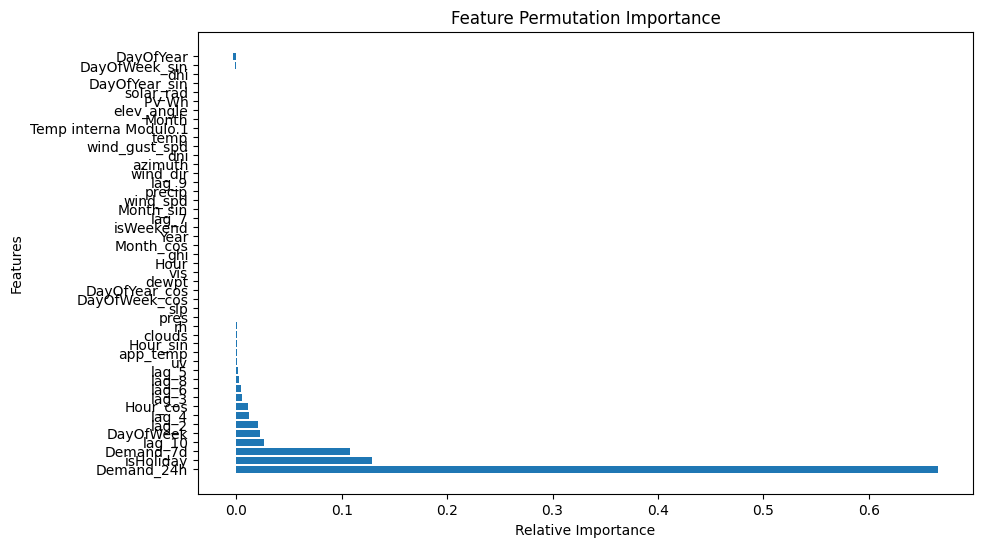

In [62]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test.to_numpy(), np.array(col_names))

In [65]:
from sklearn.model_selection import ParameterGrid

params = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.01],
    'gamma': [3, 5],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8],
    'colsample_bynode': [0.5, 0.7, 0.9, 1],
    'n_estimators': [1100]
}
def gridSearch(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123, eval_metric='mae', early_stopping_rounds=100)
        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)],
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    return config
gridSearch(params)


  1%|          | 1/128 [00:02<05:37,  2.66s/it]

MAE: 1.7861009120617077, n_Estimators: 1100, Learning_rate: 0.05, Max_depth: 5, Gamma: 3, Col_Sample_By_Tree: 0.5, Col_Sample_By_Node: 0.5


  1%|          | 1/128 [00:05<10:47,  5.10s/it]


KeyboardInterrupt: 